In [1]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import re
from shapely.wkt import dumps, loads
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from matplotlib.colors  import Normalize
import matplotlib.cm as cm
import pysal

This program uses data from the detroit database to visualize crimes, complaints, violations, and blight in 2014-15. First, load the data. The file detroit_visualization.csv was created from the parcels relation in the detroit database (see writeup for details). I'll create Shapely polygons from the poly_cyl WKT format in column poly_cyl and save them in new column poly_geom.

In [21]:
data = pd.read_csv('detroit_visualization.csv', header=0)

In [22]:
data['poly_geom'] = data['poly'].apply(loads)

In [23]:
data.head()

,parcel_name,poly,crime_count,complaint_count,violation_count,state,poly_geom
0,18615 SUNSET,"POLYGON ((19724.15636593768 19951.23651403416,...",0,0,0,not_blighted,"POLYGON ((19724.15636593768 19951.23651403416,..."
1,4147 ALGONQUIN,"POLYGON ((27527.34624451678 14967.17697772875,...",0,0,0,not_blighted,"POLYGON ((27527.34624451678 14967.17697772875,..."
2,15781 JAMES COUZENS,"POLYGON ((11271.59875266187 17474.85620640632,...",1,0,0,not_blighted,"POLYGON ((11271.59875266187 17474.85620640632,..."
3,18832 RIOPELLE,"POLYGON ((17667.99842464198 20068.04345754276,...",0,0,0,not_blighted,"POLYGON ((17667.99842464198 20068.04345754276,..."
4,14601 HARTWELL,"POLYGON ((10093.75448123575 16232.36353424741,...",0,0,0,not_blighted,"POLYGON ((10093.75448123575 16232.36353424741,..."


Next I'll instantiate the basemap that I'll use for the visualizations.

In [19]:
m = Basemap(projection = 'tmerc',
            lon_0 = -83.1,
            lat_0 = 42.4,
            ellps = 'WGS84',
            llcrnrlon = -83.3,
            llcrnrlat = 42.25,
            urcrnrlon = -82.9,
            urcrnrlat = 42.46,
            lat_ts = 0,
            resolution = 'h',
            suppress_ticks = True)

## Visualizing Crime

In order to visualize the crime data, I need to find bins for the crime_count data (these will correspond to colors in the visualization). Also, I need to make patches corresponding to the polygons which will be able to be added to a matplotlib figure.

In [10]:
np.random.seed(42)

In [11]:
nb_crimes = pysal.Natural_Breaks(data['crime_count'].values, k = 7)

In [12]:
nb_crimes.k

4

In [16]:
nb_crimes.bins

array([   0.,    2.,   14.,  237.])

So, the Natural_Breaks function found the crime_count data fell naturally into 4 bins, even though I stipulated it could use up to 7 bins. Now set column crime_bin based on these bins.

In [24]:
data['crime_bin'] = nb_crimes.yb

In [25]:
data['crime_patches'] = data['poly_geom'].apply(lambda x: PolygonPatch(x, fc='#ffffff', ec='#999999', lw=0.25, alpha=0.9, zorder=4))

Now I can visualize the crime data. Darker colors indicate a parcel had more crime incidents associated with it. Parcels with the highest number of crimes associated with them are listed (the top 10).

/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


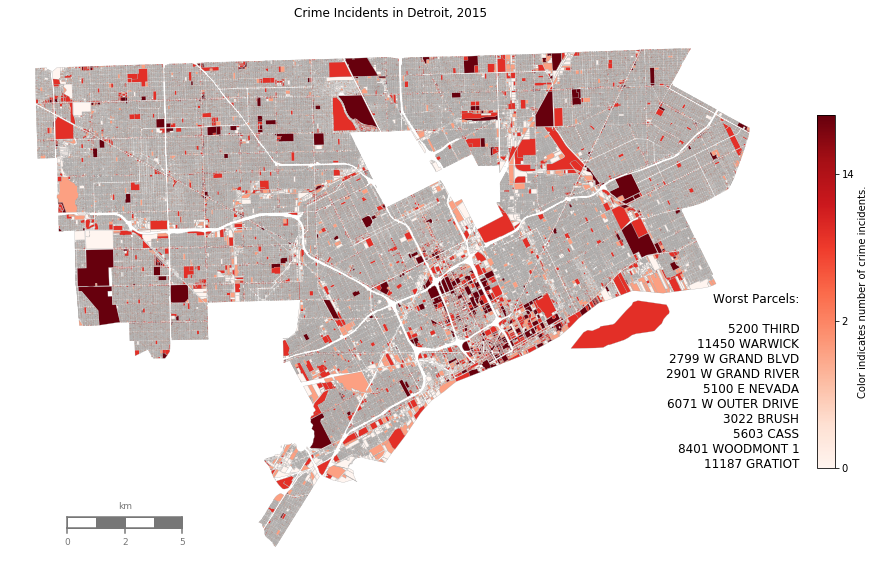

In [50]:
plt.clf()
fig = plt.figure(figsize = (17,13))
ax = fig.add_subplot(111, facecolor = 'w', frame_on = False)

cmap = plt.get_cmap('Reds')
pc = PatchCollection(data['crime_patches'], match_original = True)
norm = Normalize()
pc.set_facecolor(cmap(norm(data['crime_bin'].values)))
ax.add_collection(pc)

mpbl = cm.ScalarMappable(cmap = cmap, norm = norm)
mpbl.set_array([])
cb = fig.colorbar(mpbl, shrink = 0.5)
cb.set_ticks(np.linspace(0, 5, 5))
cb.set_ticklabels(["0", "2", "14", "237"])
cb.set_label('Color indicates number of crime incidents.')

highest = '\n'.join(t[1] for t in data.sort_values('crime_count', ascending = False)[:10].itertuples())
highest = 'Worst Parcels:\n\n' + highest
details = cb.ax.text(-1, 0 - 0.007, highest, ha='right', va='bottom', size=12)

m.fillcontinents(color = 'w', lake_color = 'w', zorder = 0)

m.drawmapscale(
    -83.3 + 0.06, 42.25 + 0.015,
    -83.3, 42.25,
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#777777',
    fontcolor='#777777',
    zorder=5)

plt.title("Crime Incidents in Detroit, 2015")
plt.savefig('detroit_crime.png', dpi = 100, alpha = True)
plt.show()

## Visualizing Complaints

For the complaint data, we can reuse the crime_patches, but set their facecolor according to complaint_bin values. First, I'll find these complaint_bin values using Natural_Breaks.

In [27]:
nb_complaints = pysal.Natural_Breaks(data['complaint_count'].values, k = 7)

In [28]:
nb_complaints.k

3

In [29]:
nb_complaints.bins

array([  0.,   1.,  90.])

In [30]:
data['complaint_bin'] = nb_complaints.yb

/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


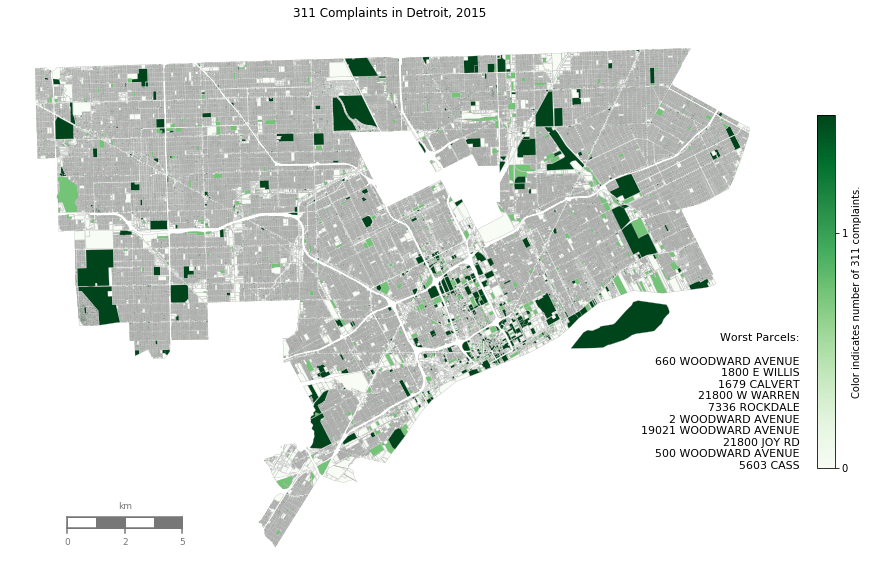

In [46]:
plt.clf()
fig = plt.figure(figsize = (17,13))
ax = fig.add_subplot(111, facecolor = 'w', frame_on = False)

cmap = plt.get_cmap('Greens')
pc = PatchCollection(data['crime_patches'], match_original = True)
norm = Normalize()
pc.set_facecolor(cmap(norm(data['complaint_bin'].values)))
ax.add_collection(pc)

mpbl = cm.ScalarMappable(cmap = cmap, norm = norm)
mpbl.set_array([])
cb = fig.colorbar(mpbl, shrink = 0.5)
cb.set_ticks(np.linspace(0, 4, 4))
cb.set_ticklabels(["0", "1", "90"])
cb.set_label('Color indicates number of 311 complaints.')

highest = '\n'.join(t[1] for t in data.sort_values('complaint_count', ascending = False)[:10].itertuples())
highest = 'Worst Parcels:\n\n' + highest
details = cb.ax.text(-1, 0 - 0.007, highest, ha='right', va='bottom', size=11)

m.fillcontinents(color = 'w', lake_color = 'w', zorder = 0)

m.drawmapscale(
    -83.3 + 0.06, 42.25 + 0.015,
    -83.3, 42.25,
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#777777',
    fontcolor='#777777',
    zorder=5)

plt.title("311 Complaints in Detroit, 2015")
plt.savefig('detroit_complaints.png', dpi = 100, alpha = True)
plt.show()

## Visualizing Violations

As for the complaint data, I will reuse the crime_patches but use facecolors based on violation_bin which is calculated using the Natural_Breaks function.

In [33]:
nb_violations = pysal.Natural_Breaks(data['violation_count'].values, k = 7)

In [34]:
nb_violations.k

5

In [35]:
nb_violations.bins

array([  0.00000000e+00,   3.00000000e+00,   6.00000000e+00,
         8.90000000e+01,   2.10980000e+04])

In [36]:
data['violation_bin'] = nb_violations.yb

/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


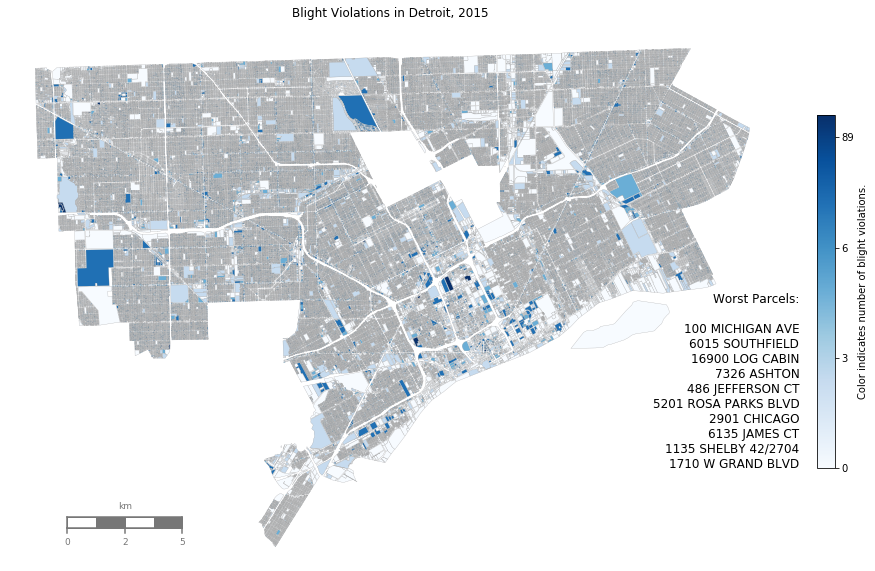

In [47]:
plt.clf()
fig = plt.figure(figsize = (17,13))
ax = fig.add_subplot(111, facecolor = 'w', frame_on = False)

cmap = plt.get_cmap('Blues')
pc = PatchCollection(data['crime_patches'], match_original = True)
norm = Normalize()
pc.set_facecolor(cmap(norm(data['violation_bin'].values)))
ax.add_collection(pc)

mpbl = cm.ScalarMappable(cmap = cmap, norm = norm)
mpbl.set_array([])
cb = fig.colorbar(mpbl, shrink = 0.5)
cb.set_ticks(np.linspace(0, 5, 5))
cb.set_ticklabels(["0", "3", "6", "89", "21,098"])
cb.set_label('Color indicates number of blight violations.')

highest = '\n'.join(t[1] for t in data.sort_values('violation_count', ascending = False)[:10].itertuples())
highest = 'Worst Parcels:\n\n' + highest
details = cb.ax.text(-1, 0 - 0.007, highest, ha='right', va='bottom', size=12)

m.fillcontinents(color = 'w', lake_color = 'w', zorder = 0)

m.drawmapscale(
    -83.3 + 0.06, 42.25 + 0.015,
    -83.3, 42.25,
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#777777',
    fontcolor='#777777',
    zorder=5)

plt.title("Blight Violations in Detroit, 2015")
plt.savefig('detroit_violations.png', dpi = 100, alpha = True)
plt.show()

## Visualizing Blight

Unlike for the other measures, visualizing blight is black and white: either a parcel is blighted or it isn't. So I'll color blighted parcels black and leave others white.

In [38]:
blight_colors = ['k' if x == 'blighted' else 'w' for x in data['state']]

/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


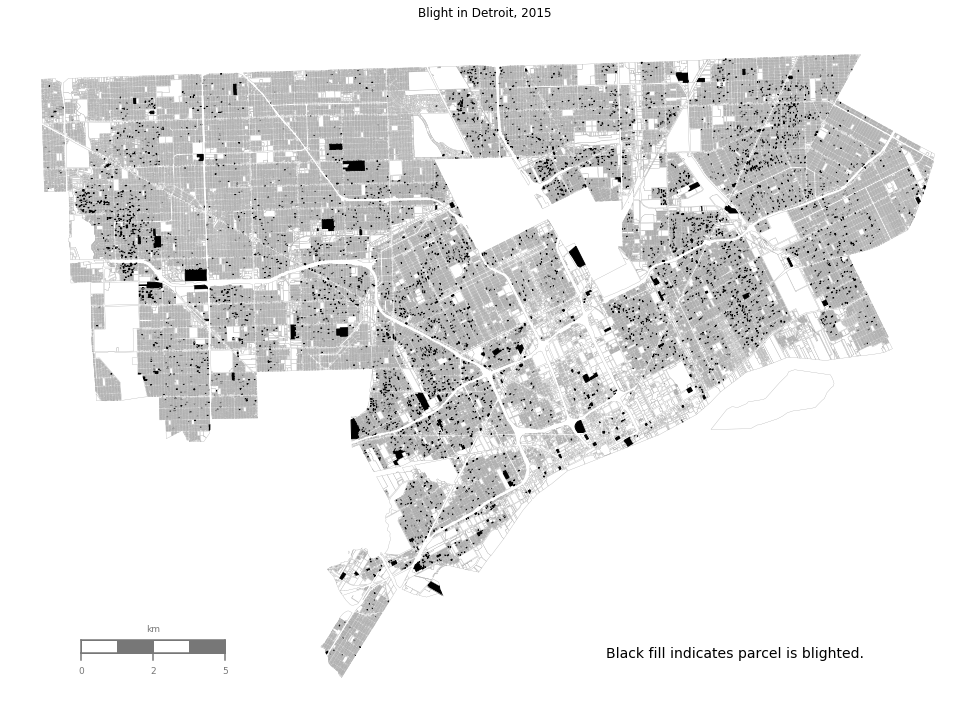

In [48]:
plt.clf()
fig = plt.figure(figsize = (17,13))
ax = fig.add_subplot(111, facecolor = 'w', frame_on = False)

pc = PatchCollection(data['crime_patches'], match_original = True)
norm = Normalize()
pc.set_facecolor(blight_colors)
pc.set_edgecolor(['k' if x == 'blighted' else '#999999' for x in data['state']])
pc.set_linewidth([1 if x == 'blighted' else 0.25 for x in data['state']])
ax.add_collection(pc)

highest = '\n'.join(t[1] for t in data.sort_values('state', ascending = False)[:10].itertuples())
highest = 'Worst Parcels:\n\n' + highest
details = cb.ax.text(-1, 0 - 0.007, highest, ha='right', va='bottom', size=10)

m.fillcontinents(color = 'w', lake_color = 'w', zorder = 0)

qualifier = ax.text(0.9, 0.05,
                   'Black fill indicates parcel is blighted.',
                   ha = 'right', va = 'bottom', size = 14, color = 'k', transform = ax.transAxes)

m.drawmapscale(
    -83.3 + 0.06, 42.25 + 0.015,
    -83.3, 42.25,
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#777777',
    fontcolor='#777777',
    zorder=5)

plt.title("Blight in Detroit, 2015")
plt.savefig('detroit_blight.png', dpi = 100, alpha = True)
plt.show()

## Neighborhoods and Parcels

/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/cathyw/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


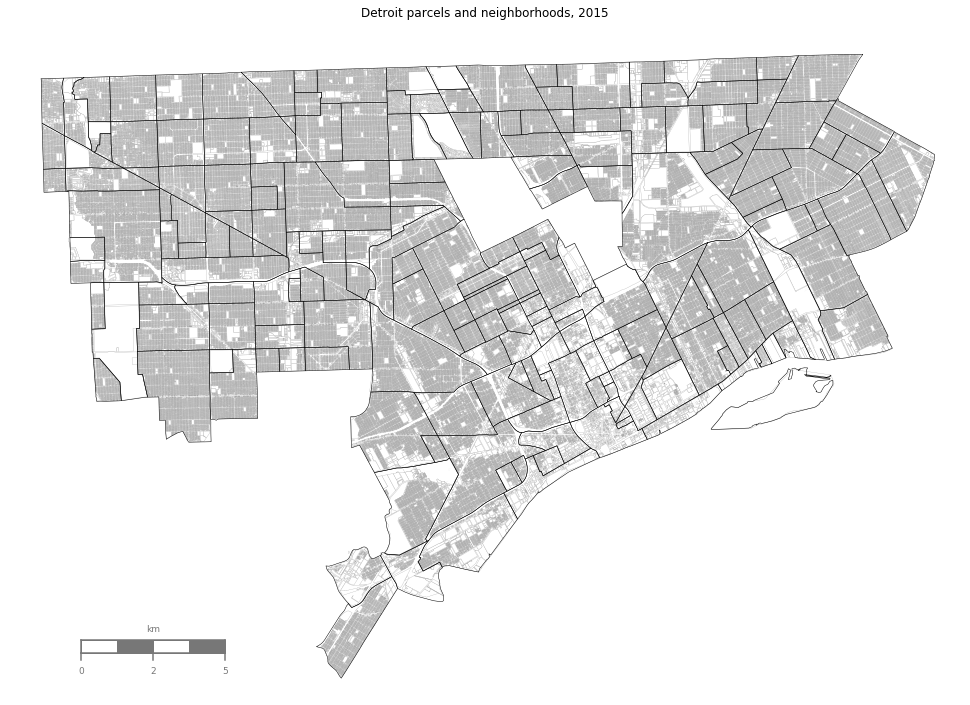

In [51]:
plt.clf()
fig = plt.figure(figsize = (17,13))
ax = fig.add_subplot(111, facecolor = 'w', frame_on = False)

cmap = plt.get_cmap('Reds')
pc = PatchCollection(data['crime_patches'], match_original = True)
norm = Normalize()
ax.add_collection(pc)

m.readshapefile('geo_export_87c965e6-3666-467e-a30f-1c5edf015752', 'nhoods')

m.fillcontinents(color = 'w', lake_color = 'w', zorder = 0)

m.drawmapscale(
    -83.3 + 0.06, 42.25 + 0.015,
    -83.3, 42.25,
    5.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#777777',
    fontcolor='#777777',
    zorder=5)

plt.title("Detroit parcels and neighborhoods, 2015")
plt.savefig('detroit_nhoods.png', dpi = 100, alpha = True)
plt.show()